In [ ]:
%pip install opentorsion
import numpy as np
import opentorsion as ot
import matplotlib.pyplot as plt

In [ ]:
class TransientExcitations():
  """
  This class is for creating transient excitations. The excitations
  currently availible are a step and an impulse.

  Attributes
  ----------
  ts : float
      Time step size
  t_excite : float
      Time instance for applying the excitation
  magnitude : float
      Excitation magnitude
  """

  def __init__(self, ts, t_excite, magnitude):
    """
    Parameters
    ----------
    ts : float
        Time step size
    t_excite : float
        Time instance for applying the excitation
    magnitude : float
        Excitation magnitude
    """

    self.ts = ts
    self.excite = t_excite
    self.magnitude = magnitude
    self.impulse = 0

  def step_next(self, t):
    """
    Calculates the next step excitation.

    Parameters
    ----------
    t : float
        Current time step

    Returns
    -------
    float
        Torque magnitude of the next step excitation
    """

    if t >= self.excite:
        return self.magnitude
    return 0

  def impulse_next(self, t):
    """
    Calculates the next impulse excitation.

    Parameters
    ----------
    t : float
        Current time step

    Returns
    -------
    float
        Torque magnitude of the next excitation
    """

    width = 0.1
    if self.excite <= t <= self.excite + width:
        self.impulse += self.magnitude * (self.ts / width)
    elif self.excite + width <= t <= self.excite + 2 * width:
        self.impulse -= self.magnitude * (self.ts / width)

    return self.impulse


In [ ]:
class PI():
  """
  This class creates a discrete PI controller for a system.

  Attributes
  ----------
  Kp : float
      Proportional gain
  Ki : float
      Integral gain
  dt : float
      Time step
  setpoint : float
      Desired system output
  limit : float
      Output limit for integrator and controller
  """

  def __init__(self, Kp, Ki, dt, setpoint, limit):
    """
    Parameters
    ----------
    Kp : float
        Proportional gain
    Ki : float
        Integral gain
    dt : float
        Time step
    setpoint : float
        Desired output
    limit : float
        Output limit for integrator and controller
    """
    self.Kp = Kp
    self.Ki = Ki
    self.dt = dt
    self.setpoint = setpoint
    self.limit = limit
    self.integral_error = 0


  def next_step(self, x):
    """
    Calculates the next controller output, taking into account the controller gains and limit.

    Parameters
    ----------
    x : float
        Current system output

    Returns
    -------
    float
        Controller output
    """
    error = self.setpoint - x
    self.integral_error += error*self.Ki*self.dt
    out = self.integral_error + error*self.Kp

    if self.integral_error > self.limit:
        self.integral_error = self.limit

    if out > self.limit:
        return self.limit

    return out

# Simulating transient torque response

## 1. Lumped element model

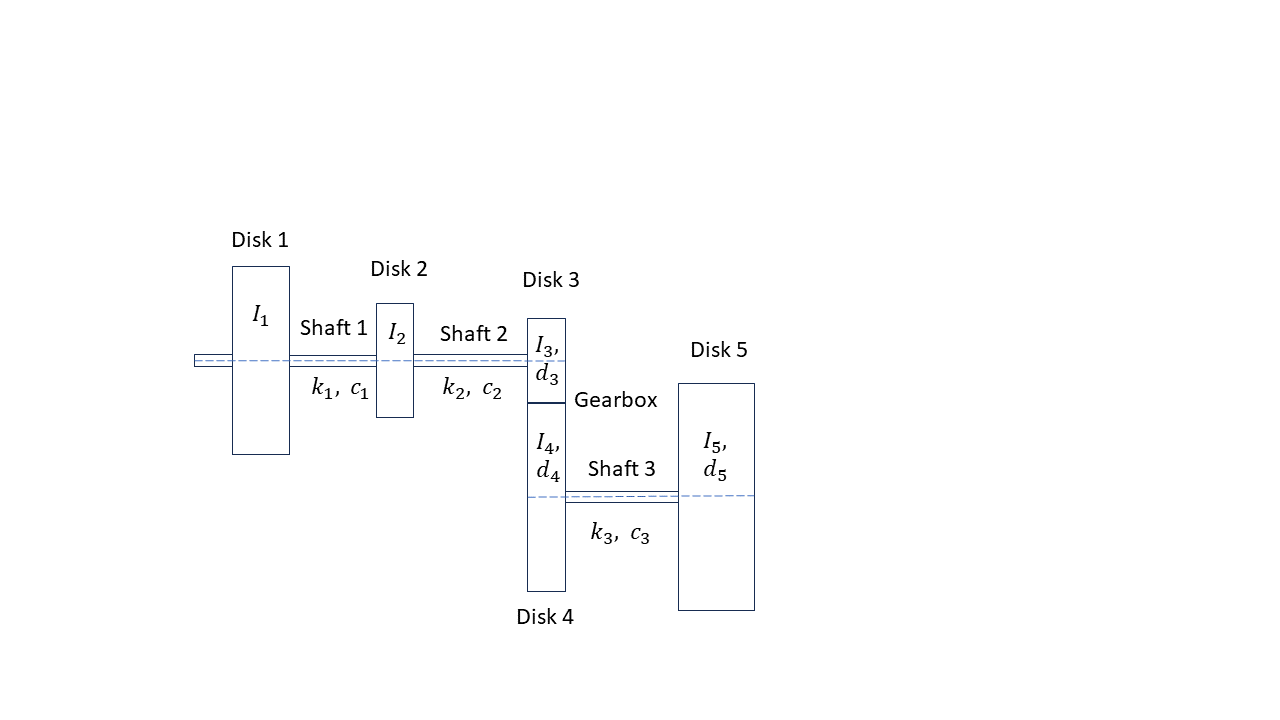




We begin by creating an assembly of the lumped element model. The model consists of 5 lumped inertia elements and 3 shaft elements. In addition, 2 of the inertia elements are also gear elements. Since the disk elements are added to the smae nodes as the gear elements, ineria is added to the system through the disks. Therfore, inertia is not added separatey to the gear elements. The parameters used are presented in the tables below.

Disk elements:

| Component | Inertia $(I_i)$ | External damping $(d_i)$ |
| --------- | --------------- | ------------------------ |
| Disk 1    | 0.5             | -                        |
| Disk 2    | 0.1             | -                        |
| Disk 3    | 0.5             | 0.2                      |
| Disk 4    | 0.1             | 0.2                      |
| Disk 5    | 1.0             | 5.0                      |

Shaft elements:

| Component | Stiffness $(k_i)$ | Internal damping $(c_i)$ |
| --------- | ----------------- | ------------------------ |
| Shaft 1    | 5000             | 10                       |
| Shaft 2    | 500              | 0.8                       |
| Shaft 3    | 500              | 0.2                      |


### 1.1 Create model

When creating the model, attention needs to be payed to defining the nodes. The nodes start from 0 and each disk is connected eiter via a shaft or a gear element. In the model below, nodes 2 and 3 are connected via gear elements, while the rest of the nodes are connected via shafts.

In [ ]:
""" Creating a model assembly """

# Model parameters
I1, k1, c1 = 0.5, 5000, 10
I2, k2, c2 = 0.1, 500, 0.8
I3, k3, c3, d3 = 0.5, 500, 5, 0.2
I4, d4 = 0.1, 0.2
I5, d5 = 1, 5

# Number of teeth in gear elements
z1, z2 = 10, 80

# Creating shaft elements
# Syntax is: ot.Shaft(node 1, node 2, Length [mm], outer diameter [mm], stiffness [Nm/rad], damping)
shaft1 = ot.Shaft(0, 1, L=None, odl=None, k=k1, c=c1)
shaft2 = ot.Shaft(1, 2, L=None, odl=None, k=k2, c=c2)
shaft3 = ot.Shaft(3, 4, L=None, odl=None, k=k3, c=c3)

shafts = [shaft1, shaft2, shaft3]

# Creating disk elements
# Syntax is: ot.Disk(node, Inertia [kgm^2], damping)
disk1 = ot.Disk(0, I=I1)
disk2 = ot.Disk(1, I=I2)
disk3 = ot.Disk(2, I=I3, c=d3)
disk4 = ot.Disk(3, I=I4, c=d4)
disk5 = ot.Disk(4, I=I5, c=d5)

disks = [disk1, disk2, disk3, disk4, disk5]

# Creating gear elements with a gear ratio of 80 / 10 = 8
# Syntax is: ot.Gear(node, Inertia [kgm^2], radius/teeth, parent)
gear1 = ot.Gear(2, 0, z1)
gear2 = ot.Gear(3, 0, z2, parent=gear1)
gears = [gear1, gear2]


# Creating an assembly of the elements
drivetrain = ot.Assembly(shafts, disks, gear_elements=gears)

### 1.2 Visualize model

The model can also be visualized in openTorsion using the Plots class and its method plot_assembly. This is demonstrated below.


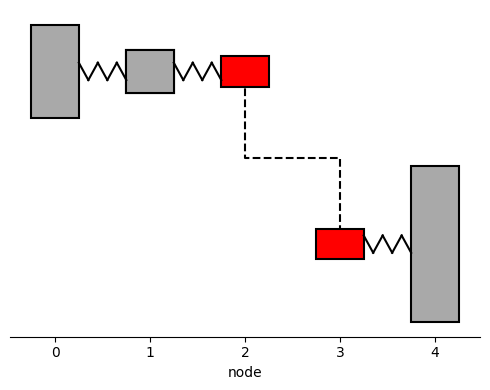

In [ ]:
# Create a plot_tool object for visualizations
plot_tools = ot.Plots(drivetrain)

# The assembly can be visualized using the plot_assembly method
plot_tools.plot_assembly()

## 2 Discrete-time state-space form


### 2.1 State-space

In order to simulate the transient response in the model, it needs to be expressed mathematically. State-space form is a common way to express the rate of change in systems. In this example we will only be needing the following state-space equation

\begin{equation}
\mathbf{\dot{x}}(t) = \mathbf{A} \mathbf{x}(t) + \mathbf{B}\mathbf{u}(t),
\end{equation}

where $\mathbf{x}$ is the state vector and $\mathbf{u}$ the input vector. Matrices $\mathbf{A}$ and $\mathbf{B}$ are commonly referred to as state and input matrix. The state vector is constructed as

\begin{equation}
\mathbf{x} =
\left(
\begin{array}{c}
     \theta_1          \\
     \theta_2          \\
     \vdots            \\
     \theta_n          \\
     \dot{\theta}_1    \\
     \dot{\theta}_2    \\
     \vdots            \\
     \dot{\theta}_n    \\
\end{array}
\right),
\end{equation}

where $\theta$ is the angular displacement of a disk. Our rotating model can be derived into state-space form by representing inertia, stifness and damping in matrix form. The rate of change is then

\begin{equation}
\dot{\mathbf{x}}(t) =
\underbrace{
\begin{bmatrix}
\boldsymbol{0} & \mathbf{I} \\
-\mathbf{M}^{-1}\mathbf{K} & -\mathbf{M}^{-1}\mathbf{C}
\end{bmatrix}}_\mathbf{A}
\mathbf{x}(t)
+
\underbrace{
\begin{bmatrix}
\boldsymbol{0} \\
\mathbf{M}^{-1}
\end{bmatrix}}_\mathbf{B}
\mathbf{u}(t).
\end{equation}

In rotor dynamics, matrices $\mathbf{M}$, $\mathbf{K}$, and $\mathbf{C}$ are know as the mass, stiffness, and damping matrix. In openTorsion the state matrix $\mathbf{A}$ and the input matrix $\mathbf{B}$ can be calculated by calling the state_space method of the Assembly class. This is demonstrated below.

In [ ]:
""" Calculating the state and input matrices """

A, B = drivetrain.state_space()

### 2.2 Discrete-time

In order to calculate the states in the model, the model needs to be discretized into a finite number of steps. State-space form in discrete-time can be expressed as

\begin{equation}
\mathbf{x}(h+1) =
\mathbf{A_d}\mathbf{x}(h)
+
\mathbf{B_d}\mathbf{u}(h),
\end{equation}

where $\mathbf{A_d}$ and $\mathbf{B_d}$ is the discrete state and input matrix. They can be calculated using matrix exponential and a constant time step $\Delta t$

\begin{equation}
\begin{bmatrix}
\mathbf{Ad} & \mathbf{Bd} \\
\boldsymbol{0} & \mathbf{I}
\end{bmatrix}
= \exp(
\begin{bmatrix}
\mathbf{A} & \mathbf{B} \\
\boldsymbol{0} & \boldsymbol{0}
\end{bmatrix}
\Delta t).
\end{equation}

In openTorsion the discrete state and input matrices can be calculated by calling the continuous_2_discrete method of the Assembly class. This is demonstrated in the code block below.

In [ ]:
""" Discretization of the state and input matrices """

ts = 0.001  # Time step
# Syntax is: self.continuous_2_discrete(state matrix, input matrix, time step)
Ad, Bd = drivetrain.continuous_2_discrete(A, B, ts=0.001)

## 3 Simulation


### 3.1 Controlling the model

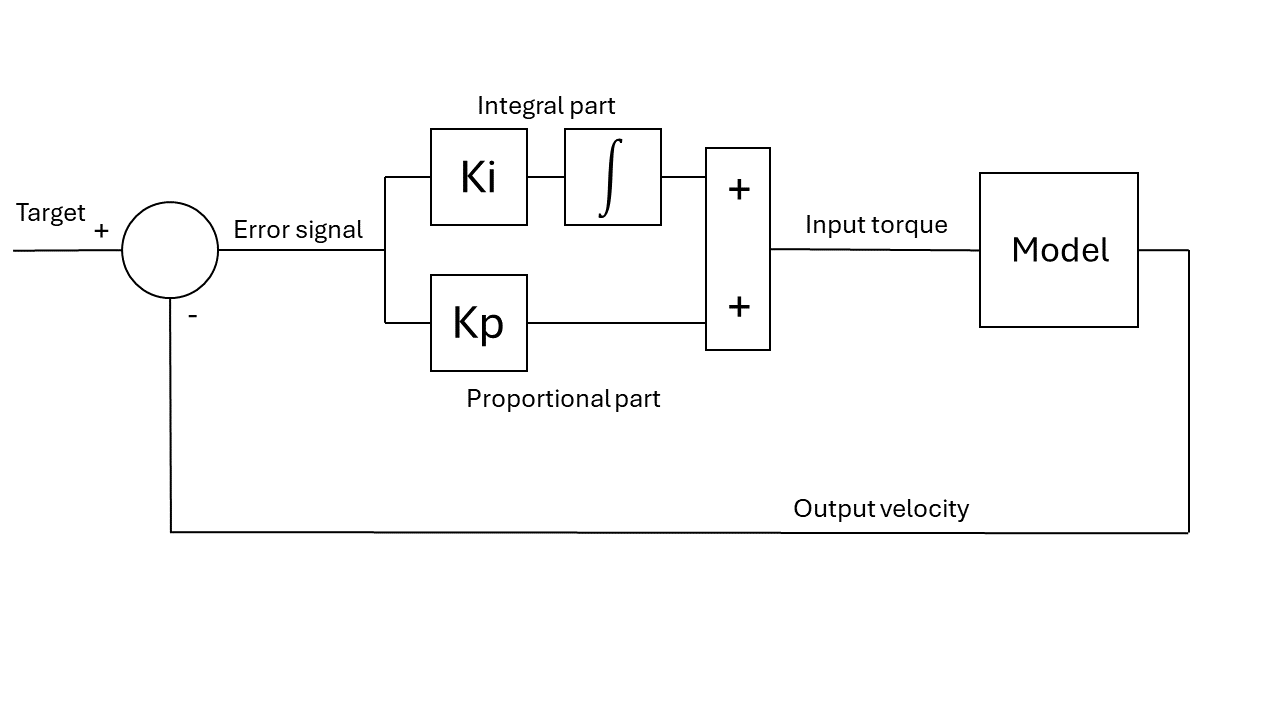

The model can be controlled using a simple PI controller. The controller calculates the error, i.e. the diffrence between the desired model output and the current model output, commonly referred to as a negative feedback loop. This error is passed to the controller's proportional and intergal parts. Here, the signal is transalted into a more suitable input for the model. A class for such a controller is created below.

In [ ]:
class PI():
  """
  This class creates a discrete PI controller for a system.

  Attributes
  ----------
  Kp : float
      Proportional gain
  Ki : float
      Integral gain
  dt : float
      Time step
  setpoint : float
      Desired system output
  limit : float
      Output limit for integrator and controller
  """

  def __init__(self, Kp, Ki, dt, setpoint, limit):
    """
    Parameters
    ----------
    Kp : float
        Proportional gain
    Ki : float
        Integral gain
    dt : float
        Time step
    setpoint : float
        Desired output
    limit : float
        Output limit for integrator and controller
    """
    self.Kp = Kp
    self.Ki = Ki
    self.dt = dt
    self.setpoint = setpoint
    self.limit = limit
    self.integral_error = 0


  def next_step(self, x):
    """
    Calculates the next controller output, taking into account the controller gains and limit.

    Parameters
    ----------
    x : float
        Current system output

    Returns
    -------
    float
        Controller output
    """
    error = self.setpoint - x
    self.integral_error += error*self.Ki*self.dt
    out = self.integral_error + error*self.Kp

    if self.integral_error > self.limit:
        self.integral_error = self.limit

    if out > self.limit:
        return self.limit

    return out

In [ ]:
""" Creating controller  """

# Parameters
Kp = 3
Ki = 3
target = 200 # RPM
limit = 20   # Torque (Nm)

# Syntax is: ot.PI(Proportional gain, Integral gain, Time step [s], Target velocity [RPM], Limit [Nm])
controller = PI(Kp, Ki, ts, target, limit)

### 3.2 Excitations for the model

Excitations load the model with a torque, most often, acting in the opposite direction of rotating direction. OpenTorsion is equiped with a class for creting a transient step and impulse excitation. An excitation object is created in the code block below.


In [ ]:
""" Creating an transient excitation object """

# Parameters
t_excite = 3    # Time (s)
magnitude = 30  # Torque (Nm)

# Syntax is: ot.TransientExcitations(Time step [s], Time for applying excitation [s], Magnitude [Nm])
excitations = TransientExcitations(ts, t_excite, magnitude)

### 3.3 Simulating torque response

Simulating the torque response begins with calculating all the states of the model for the simulated time. An initial state needs to be defined, after which the next state can be calculated by adding the product of the discrete state matrix $\mathbf{A_d}$ and the previous state vector $\mathbf{x}$ with the product of discrete input matrix $\mathbf{B_d}$ and the input vector $\mathbf{u}$. You might remember this from the first equation in section $2.2$.

The shapes of vector $\mathbf{x}$ and $\mathbf{u}$ can be obtained from the shape of mass matrix $\mathbf{M}$. Keep in mind that the state vector holds both the angular displacement and velocity, making it twice the size of the input vector. The controller and excitations object can be used to calculate the input vector $\mathbf{u}$.

In [ ]:
""" Calculating the states of the model for a step excitation """

# Defining necessary variables
t_end = 6                                             # Simulation time
x0 = np.zeros(2 * drivetrain.M.shape[0])              # Initial state
u0 = np.zeros(drivetrain.M.shape[0])                  # Input vector
iterations = np.linspace(0, t_end, int(t_end/0.001))  # Iterations based on simulation time and time step
rpm = 60 / (2 * np.pi)                                # Conversion from rad/s to RPM
states_step = []
rpms = []

# Calculating all the states
for i in iterations:
    u0[0] = controller.next_step(x0[drivetrain.M.shape[0]] * rpm)
    u0[-1] = excitations.step_next(i)
    x0 = Ad @ x0 + Bd @ u0
    states_step.append(x0)
    rpms.append(x0[drivetrain.M.shape[0]] * rpm)
states_step = np.array(states_step)
rpms = np.array(rpms)

The following function can be used to plot the velocity of the model compared to the target velocity. It takes a time and velocity vector as inputs as well as the target velocity.

In [ ]:
""" Plots the angular velocity of a model """

def plot_rpm(t, rpm, target):
  """
    Parameters
    ----------
    t : array
        Time vector
    rpm : array
        Velocity vector
    target : float
        Target velocity
    """
  plt.figure(figsize=(6, 4))
  plt.plot(t, rpm, label='Model velocity')
  plt.axhline(target, color='g', linestyle='--', label='Target velocity')

  plt.title('Angular velocity')
  plt.xlabel('Time (s)')
  plt.ylabel('Velocity (RPM)')
  plt.legend()
  plt.tight_layout()
  plt.show()

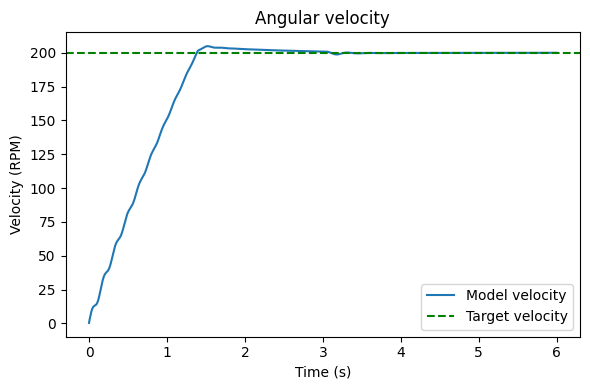

In [ ]:
""" Plotting the velocity of the model """

# Syntax is: plot_rmp(time vector, velocity vector, target velocity)
plot_rpm(iterations, rpm, target)

Now that the states are known, the shaft torque can be calculated. This can be done according to

\begin{equation}
T_i = k_i(\theta_i - \theta_{i+1}).
\end{equation}

In addition, possible gear ratios needs to be accounted for when calculating the shaft torque. In openTorsion both gear elements are merged into one rotating disk, where the rotation angle is affected by the gear ratio. Therfore, the rotation angle of the gear disk or the following disk needs to be eiter multiplied or divided with the gear ratio. In case the gear ratio is bigger than 1, the gear elemet is divided with the gear ratio. On the other hand, if the gear ratio is smaller than 1, the disk sequent to the gear element is multipied with the gear ratio. This is demonstrated in equation


\begin{equation}
T_i = k_i(\frac{\theta_i}{i} - \theta_{i+1}),
\end{equation}
when $i > 1$ and

\begin{equation}
T_i = k_i(\theta_i - \theta_{i+1} i),
\end{equation}
when $i < 1$.

We define a separate function for calculating the shaft torque in the model at all points of interest.


In [ ]:
""" Calculates the shaft torque between desired indices. Keep in mind that a
gear ratio over 1 should be passed to the function at the index of the gear
element, while a gear ratio under one should be passed to the index after the
gear element. In addition, the indecies in the index list should correspond to
the disk prior to the shaft. """

def shaft_torque(states, k_list, idx_list, ratio_list):
  """
    Parameters
    ----------
    states : ndarray
        Matrix with the calculated states
    k_list : list
        List with stiffnesses
    idx_list : list
        List with indices
    ratio_list : list
        List with gear ratios

    Returns
    -------
    Calculated shaft torque
    """
  torques = []
  for i, k in enumerate(k_list):
      if ratio_list[i] >= 1:
          T = k * (np.abs(states[:, idx_list[i]]) / ratio_list[i] - np.abs(states[:, idx_list[i] + 1]))
      else:
          T = k * (np.abs(states[:, idx_list[i]]) - np.abs(states[:, idx_list[i] + 1]) * ratio_list[i])
      torques.append(T)

  return torques

In [ ]:
""" Calculating torque responses """

i = z2 / z1   # Gear ratio
# Syntax is: shaft_torque(states matrix, stiffnesses list, indices list, ratios list)
torques_step = shaft_torque(states_step, [k2, k3], [1, 2], [1, i])

### 3.4 Visualizing torque response

The torque responses can be plotted using the following function.


In [ ]:
""" Plots the shaft torques in a model """

def plot_torque(t, torques):
  """
    Parameters
    ----------
    t : array
        Time vector
    torques : array
        Torque vector
    """
  plt.figure(figsize=(7,4))
  for i, torque in enumerate(torques):
      plt.plot(t, torque, label=f'Shaft {i+1}')

  plt.title('Simulated torque response')
  plt.xlabel("Time (s)")
  plt.ylabel("Torque (Nm)")
  plt.legend()
  plt.tight_layout()
  plt.show()

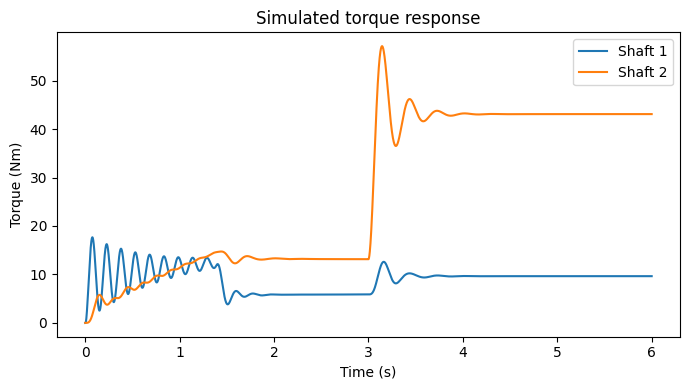

In [ ]:
""" Plotting shaft torques """

# Syntax is: plot_torque(time vector, torque vector)
plot_torque(iterations, torques_step)

# 4 Impulse example




### 4.1 Simulate impulse response

In this example the torque response to an impulse is simulated. The simulation is similar to the previous step excitation case. However, the impulse_next method of the excitations instance should be called instead of step_next. This is implemented in the code block below.

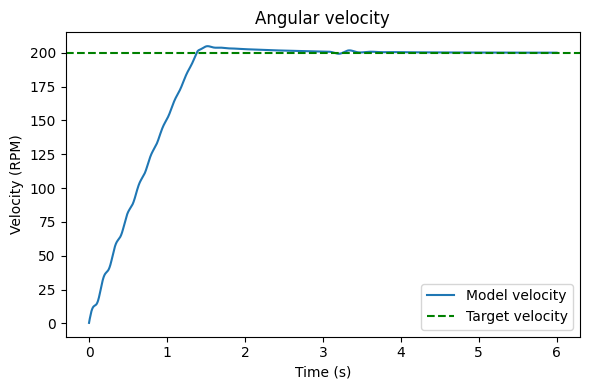

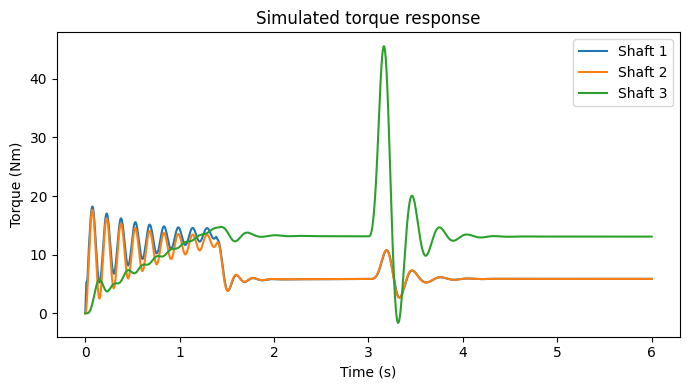

In [ ]:
""" The impulse example is made with the same model, controller and excitation parameters. """

# Defining necessary variables
x0 = np.zeros(2 * drivetrain.M.shape[0])
u0 = np.zeros(drivetrain.M.shape[0])
states_impulse = []
rpms = []

# Calculating states
for i in iterations:
    u0[0] = controller.next_step(x0[drivetrain.M.shape[0]] * rpm)
    u0[-1] = excitations.impulse_next(i)
    x0 = Ad @ x0 + Bd @ u0
    states_impulse.append(x0)
    rpms.append(x0[drivetrain.M.shape[0]] * rpm)
states_impulse = np.array(states_impulse)
rpms = np.array(rpms)

# Plotting rpm
plot_rpm(iterations, rpm, target)

# Calculating shaft torque for shaft 1, 2 and 3
torques_impulse = shaft_torque(states_impulse, [k1, 500, 500], [0, 1, 2], [1, 1, 8])

# Plotting shaft torques
plot_torque(iterations, torques_impulse)